In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# Example how two combine two independent streams in a single model

# This path has weights
input_1 = keras.Input(shape=(256,256,3), batch_size=1)
x1 = keras.layers.Dense(64, activation="relu")(input_1)
x1 = keras.layers.Dense(10, activation="sigmoid")(x1)

# This path has no weights, only computations
input_2 = keras.Input(shape=(256,256,3), batch_size=1)
x2 = input_2 + 100 # the + will be converted to tf.add behind the scenes because input_2 is a tensorflow/keras object
x2 = x2 / 5

# model 1 - with weights
model = keras.Model(inputs=[input_1], outputs=[x1])
model.summary()
print("\n\n")

# model 2 - weithout weights
model2 = keras.Model(inputs=[input_2], outputs=[x2])
model2.summary()
print("\n\n")

# model 3 - compute both pathways in a single model even though they are independent from each other
# NOTE: operations from the previous models are reused 
model3 = keras.Model(inputs=[input_1,input_2], outputs=[x1,x2])
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 256, 256, 3)]        0         
_________________________________________________________________
dense (Dense)                (1, 256, 256, 64)         256       
_________________________________________________________________
dense_1 (Dense)              (1, 256, 256, 10)         650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(1, 256, 256, 3)]        0         
_________________________________________________________________
tf.__operators__.add (TFOpLa (1, 256, 256, 3)          0         
___________________________________________

2022-03-07 11:53:46.937105: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 11:53:47.413409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11415 MB memory:  -> device: 0, name: TITAN Xp, pci bus id: 0000:0a:00.0, compute capability: 6.1


In [ ]:
# Intermediat computations V1: Don't do this

# build models
UNet = build_UNet() # function that returns the model object, e.g. the output of keras.Model()
CNN  = keras.load_model()

# use models with intermediate computations
for i in range(10):
    
    x_train,y_train = ...
    
    with tf.gradient_tape():
        
        x = UNet(x_train)
        x = tf.signal.fft2d(x) # This will create NEW operations every time it is executed
        y = CNN(x)

        ...

In [ ]:
# Intermediat computations V2: Better do this

# build models
UNet = build_UNet() # function that returns the model object, e.g the output of keras.Model()
Proc = build_processing_model() # function that returns the model object. The 'model' might have no weights, only compute steps... 
CNN  = keras.load_model()

# use models with intermediate computations
for i in range(10):
    
    x_train,y_train = ...
    
    with tf.gradient_tape():
        
        x = UNet(x_train)
        x = Proc(x) # This will REUSE the operations defined in the Proc 'model'
        y = CNN(x)

        ...

# Modularization example

In [24]:
# util functions to building a model (only tf/keras code)
def fft2d(c):
    # fft for a color channel
    c = keras.backend.cast(c, tf.complex64)
    c = keras.layers.Lambda(tf.signal.fft2d)(c)
    c = keras.layers.Lambda(tf.signal.fftshift)(c)

    return c

def ifft2d(c):
    # ifft for a color channel
    c = keras.layers.Lambda(tf.signal.ifftshift)(c)
    c = keras.layers.Lambda(tf.signal.ifft2d)(c)
    c = keras.backend.cast(c, tf.uint8)

    return c

def fft2d_rgb(img):
    # splits an img in r,g,b channels and returns the fft per channel
    
    # remove batch dimension -> shape should now be (w,h,c)
    img = tf.squeeze(img, axis=0) 

    r = tf.keras.layers.Lambda(lambda x: x[:,:,0])(img)
    g = tf.keras.layers.Lambda(lambda x: x[:,:,1])(img)
    b = tf.keras.layers.Lambda(lambda x: x[:,:,2])(img)
    
    r = fft2d(r)
    g = fft2d(g)
    b = fft2d(b)

    return r,g,b 
    
def ifft2d_rgb(r,g,b):
    
    r = ifft2d(r)
    g = ifft2d(g)
    b = ifft2d(b)
    img = tf.stack([r,g,b], axis=-1)
    
    return img

def normalize(c):
    return (c - tf.reduce_min(c)) / (tf.reduce_max(c) - tf.reduce_min(c))

def fft_diff(c1,c2, threshold):
    
    m = normalize(tf.math.log(tf.abs(c1-c2)))
    m = tf.cast(tf.math.greater(m, threshold), tf.complex64)
    return m

def blend_fft(mask, c1, c2):
    return (1 - mask) * c1 + mask * c2


In [25]:
# build the model
input_1 = keras.Input(shape=(256,256,3), batch_size=1)
input_2 = keras.Input(shape=(256,256,3), batch_size=1)

r1,g1,b1 = fft2d_rgb(input_1)
r2,g2,b2 = fft2d_rgb(input_2)

mask_r = fft_diff(r1, r2, 0.5)
mask_g = fft_diff(g1, g2, 0.5)
mask_b = fft_diff(b1, b2, 0.5)

r = blend_fft(mask_r, r1, r2)
g = blend_fft(mask_g, g1, g2)
b = blend_fft(mask_b, b1, b2)

img_with_mixed_fft = ifft2d_rgb(r,g,b)

model  = keras.Model(inputs=[input_1,input_2], outputs=[img_with_mixed_fft])

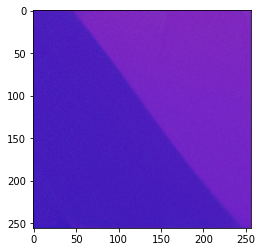

In [28]:
# use the model
img_1 = np.array(Image.open('./img_1.png').convert('RGB'))
img_1 = np.expand_dims(img_1, axis=0) # fake batch dimension (1,256,256,3)

img_2 = np.array(Image.open('./img_2.png').convert('RGB'))
img_2 = np.expand_dims(img_2, axis=0) # fake batch dimension (1,256,256,3)

img_blend = model([img_1,img_2])[0]
plt.imshow(img_blend, cmap='gray')